## TC 5033
### Word Embeddings

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project: 
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)
|



Import libraries

In [1]:
# %conda install -q conda-forge::matplotlib conda-forge::transaction conda-forge::scikit-learn conda-forge::btrees conda-forge::zodb

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import urllib.request

import transaction, ZODB, ZODB.FileStorage

from pathlib import Path
from BTrees.OOBTree import OOBTree

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Download file from internet and unzip it

In [3]:
FILE = "../embeddings/glove.6B.zip"

path = Path(FILE)

if not path.exists():
    urllib.request.urlretrieve("https://nlp.stanford.edu/data/glove.6B.zip", FILE)

if path.exists():
    with zipfile.ZipFile(FILE, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            if not os.path.exists(os.path.join("../embeddings", filename)):
                zip_ref.extract(filename, '../embeddings')

Create references to the embedding files

In [4]:
EMBEDDINGS_FILE = lambda dim: f"../embeddings/glove.6B.{dim}d.txt"

In [5]:
def create_embedding_btree(file):
    btree = OOBTree()
    with open(file) as ref:
        for line in ref:
            row = line.split(" ")
            btree.update({f"{row[0]}": [float(v) for v in row[1:]]})
    return btree

In [6]:
embeddings_btree = create_embedding_btree(EMBEDDINGS_FILE(50))

Create class that contains the logic for ploting embeddings, compute most similars and compute analogy.
For the implementation of the class we decided to use BTree like data structure because in one hand give us O(log n) access times to each word vector on the other hand it give us faster warm up times or we don't have to wait until the complete dict is loaded in memory to work with it.

In [ ]:
class EmbeddingDict:

    def __init__(self, filepath):
        self.db = ZODB.DB(filepath)
        self.conn = self.db.open()
        self.root = self.conn.root()

    def save(self, object):
        """saves the object in the database"""
        self.root['embedding'] = object
        transaction.commit()

    def __getattr__(self, name):
        """get the dict class from the database, usually for calling methods like keys() or items()"""
        return self.root[name] if name is 'embedding' else None

    def __getitem__(self, name):
        """returns a vector from the embedding dict"""
        return self.root['embedding'][name]
    
    def __del__(self):
        """closes de database"""
        self.db.close()

For ploting embeddings we use two techniques PCA (Principal Component Analisys) and TSNE (t-distributed stochastic neighbor embedding), both classes from sklearn.

In [8]:
def plot_embeddings(self, words2show, Model = PCA):
    """Plots the words in a scatter plot"""
    vectors = [ self[word] for word in words2show ]
    model = Model(n_components=3, random_state=42)
    result = model.fit_transform(np.array(vectors))
    
    plt.figure(figsize=(12,8))
    plt.scatter(result[:,0], result[:,1], c=result[:,2])
    
    for i, word in enumerate(words2show):
        plt.annotate(word, (result[i,0], result[i, 1]))
    plt.show()


EmbeddingDict.plot_embeddings = plot_embeddings

To find the most similar words given a seed word we compute the cosine similarity of the vector against each vector in the database.

In [26]:
def cosine_similarity(self, vec1, vec2):
    """computes the cosine similarity"""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def find_most_similar(self, needle, top_n=10):
    """finds the most similar words given seed word"""
    result = self[needle]
    word_list = []
    for word, vector in self.embedding.items():
        if word not in [needle]:
            similarity = self.cosine_similarity(result, vector)
            word_list.append((float(similarity), word))
    word_list.sort(reverse=True)
    return word_list[:top_n]


EmbeddingDict.cosine_similarity = cosine_similarity
EmbeddingDict.find_most_similar = find_most_similar

The analogy function works substracting word1 minus word2 plus word3, then calculates the cosine similarity of the resulting vector against each vector in the database

In [28]:
def analogy(self, word1, word2, word3):
    """computes the analogy for the given words: word3 + (word2 - word1)"""
    vector1 = self[word1]
    vector2 = self[word2]
    vector3 = self[word3]
    
    result = np.add(np.subtract(vector2, vector1), vector3)
    max_similarity = -float('inf')
    best_word = None
    
    for word, vector in self.embedding.items():
        if word not in [word1, word2, word3]:
            similarity = self.cosine_similarity(result, vector)
            if similarity > max_similarity:
                max_similarity = float(similarity)
                best_word = word
    
    return best_word, max_similarity

EmbeddingDict.analogy = analogy

Save embedding vectors to a file in hdd

In [ ]:
# Create an EmbeddingDict with a filepath for storing the dict or if exists to retrieve data from it
dict = EmbeddingDict('../embeddings/glove_embeddings.fs')

In [ ]:
# no need to save dict again if you have *.fs file in your filesystem
# dict.save(embeddings_btree)
# del dict

In [32]:
def show_n_words(dict, n_words=10):
    l = random.choices(dict.embedding.keys(), k=n_words)
    for k in l:
        print(f"{k} => {str(dict[k][0:10])[:-1]}...")

In [33]:
show_n_words(dict)

gahal => [-0.54487, -0.40854, 0.54183, -0.043211, -1.053, 1.1336, -0.2988, 0.40283, -0.58877, -0.36177...
well-publicised => [0.35909, -0.32049, -0.90363, 0.21347, -0.67899, 0.9228, 0.7021, 0.70167, 0.47803, 0.31104...
ogema => [-0.10157, -0.27742, -0.13381, 0.02307, -0.014902, 0.30838, 0.43761, 0.25734, 0.54809, 0.65755...
biesbosch => [0.14762, -0.15604, -0.71543, 0.36869, -0.75751, -0.93293, 0.29372, 0.5588, 0.64176, 0.12519...
consummation => [1.1987, -0.36843, -1.6037, 0.4003, 0.3876, 0.34654, 0.93256, 0.63589, 0.088879, 1.0589...
gannibal => [-0.34435, 0.41693, 0.5948, 0.029475, -0.088903, -0.1403, 0.42458, -0.26995, 0.14853, 0.11816...
melded => [0.35181, -1.2519, -0.43686, -0.4803, -0.02108, 0.62654, -0.45279, -0.4885, -0.61377, 0.71134...
tajudeen => [-0.71018, 0.019386, 0.1448, 0.97595, -0.32311, -0.24143, 0.63123, 1.1226, -1.0613, -0.13782...
maximising => [0.40099, -0.037391, 0.47837, -0.31433, 0.51588, -0.09621, 0.8516, 0.053951, 1.2483, 0.84704...
yanomamo => [-0.55845, -

#### Plot Embeddings

In [15]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips', 
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']

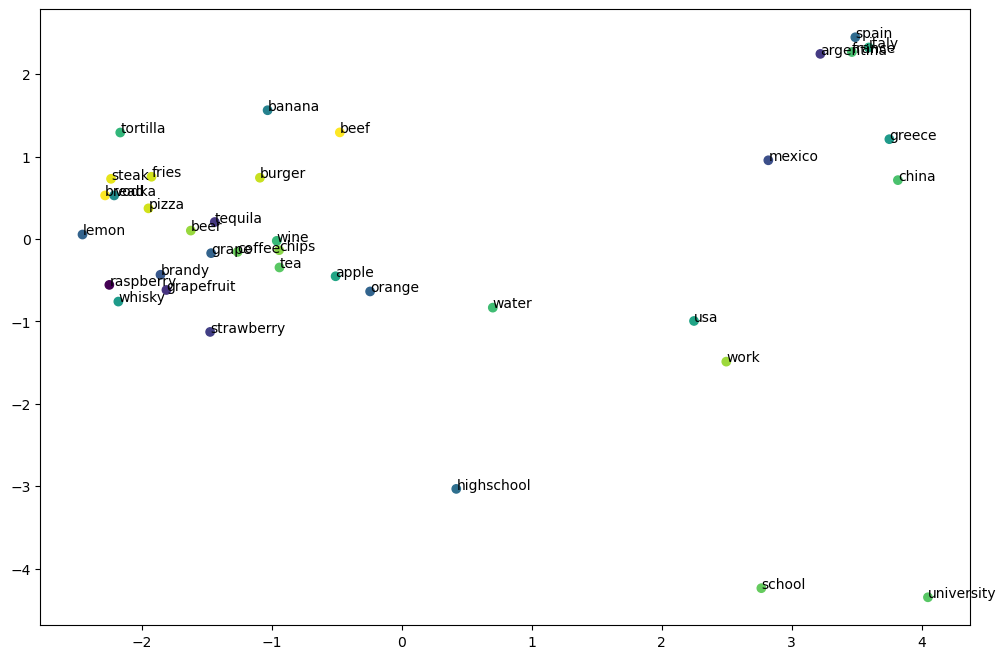

In [16]:
dict.plot_embeddings(words)

In [17]:
words3 = ['pear', 'plum', 'peach', 'lemon', 'grapes',
         'cabbage', 'eggplant', 'carrot', 'mushroom', 'potato',
         'book', 'article', 'newspaper', 'literature', 'novel',
         'magazine', 'press']

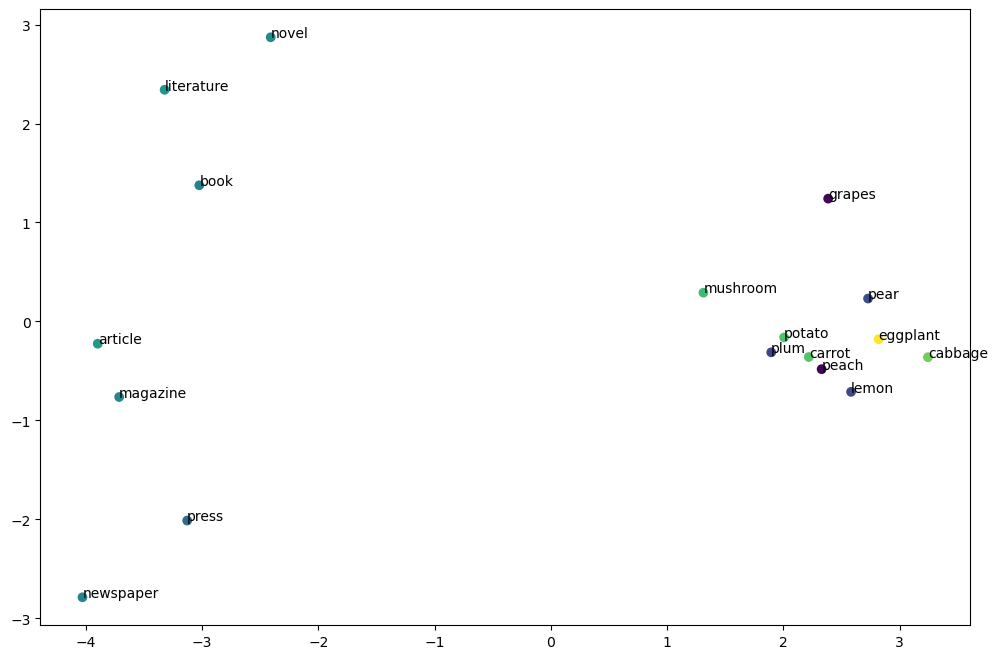

In [18]:
dict.plot_embeddings(words3)

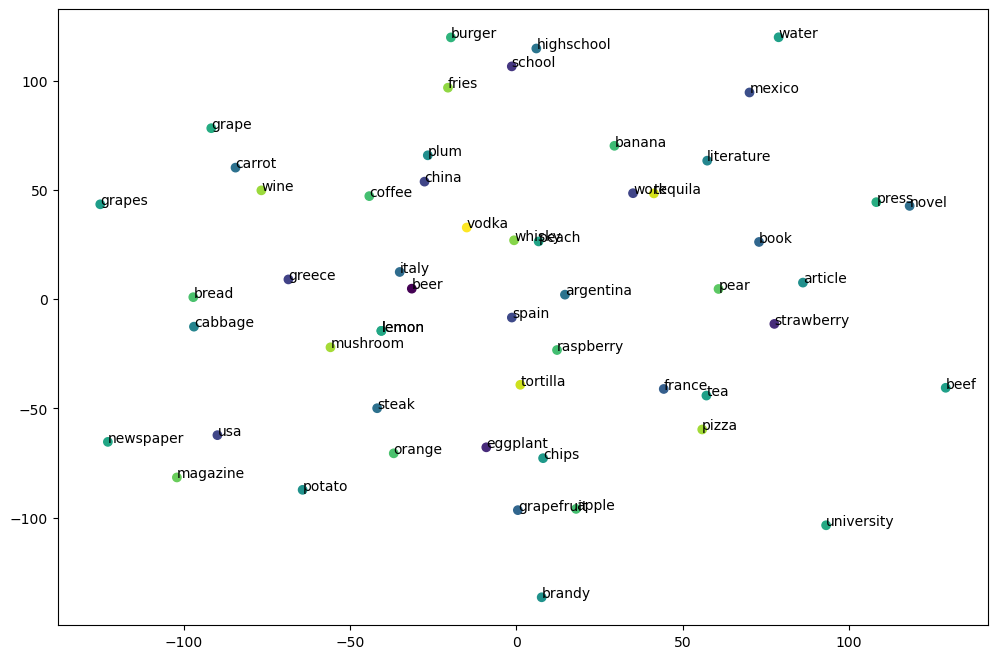

In [19]:
dict.plot_embeddings(words + words3, Model=TSNE)

#### Compute the analogy

In [29]:
dict.analogy('man', 'king', 'woman')

('queen', 0.8609581258578943)

#### Find the most similar word

In [27]:
dict.find_most_similar('mexico')

[(0.8550674735062006, 'mexican'),
 (0.8496898990100274, 'venezuela'),
 (0.8490317678971009, 'colombia'),
 (0.8446482641983609, 'peru'),
 (0.8439290136916645, 'chile'),
 (0.8362627872195747, 'puerto'),
 (0.8194695530350028, 'rico'),
 (0.8125205402325332, 'cuba'),
 (0.8113810916121008, 'guatemala'),
 (0.8096755912322255, 'panama')]